In [1]:
# install required system dependencies
!apt-get install -y xvfb x11-utils 
!apt-get install x11-utils > /dev/null 2>&1
!pip install PyVirtualDisplay==2.0.* \
PyOpenGL==3.1.* \
PyOpenGL-accelerate==3.1.* \
gym[box2d]==0.17.* 
!pip install pyglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [2]:
from gym import Env, spaces
import numpy as np
import random
import time
from matplotlib import pyplot as plt

In [3]:
class SteeringWheelEnv(Env):
  """
  Environment to replicate automated steering of the wheel in an environment (road)
  """
  def __init__(self):

    # The first set of action is the degree of turn
      # -1 indicates complete left turn, 1 indicates complete right turn and 0 indicates wheel is aligned centered
    # The second set of action is change in speed of the vehicle.
      # Here we will consider 0 as speed reduction and 1 as speed increase 
    #self.action_space = spaces.MultiDiscrete([3,2])        
    self.action_space = spaces.Tuple((
                                        spaces.Box(low=np.array([-1]), high=np.array([1])),
                                        spaces.Discrete(2)
                                      ))


    # degree of turn of the road from left(negative) to right(positve)
    # self.observation_space = spaces.Box(low=np.array([-1]), high=np.array([1]))    
    
    # The environment returns 
      # (Continuous)the amount of turn required for the road ahead. Here -1 indicates left turn, 0 indicates straight road and 1 indicating right turn.
      # (Continuous)the position of the vehicle with respect to the current road lane. -1 indicating extreme left, 0 for center and 1 for extreme right
    self.observation_space = spaces.Tuple((
                                            spaces.Box(low=np.array([-1]), high=np.array([1])),
                                            spaces.Box(low=np.array([-1]), high=np.array([1]))
                                          ))

    # intial randomized turn of the road
    self.road_turn = random.uniform(-1,1)
    # intial position of vehicle on the orad
    self.road_position = random.uniform(-1,1)
    # amount of turn ± from 0 that will be considered almost straight road. Used by the state road_turn
    self.turn_margin_to_center = 0.2

    # duration of drive
    self.drive_duration = 100   # seconds

    # margin of error accepted for the vehicle to be considered aligned with the road (center). Used by the state road_position
    self.vehicle_road_center_threshold = 0.4


  def step(self, action):
    # decrease time step
    self.drive_duration -= 1

    action_turn, action_speed = action        # float, integer

    # get updated road postion of vehicle after action execution
    self.road_position = self.get_updated_road_position(self.road_position, self.road_turn, action_turn, action_speed)
    # assigning default reward to action
    reward = -1

    if self.road_turn < -self.turn_margin_to_center or self.road_turn > self.turn_margin_to_center:     # road is turning left or right
      # when turning need to reduce speed
      if action_speed == 0:
        if self.road_position>=-self.vehicle_road_center_threshold and self.road_position<=self.vehicle_road_center_threshold:
          # wheel and road turn are aligned straight. The vehicle is almost center of the road
          reward = 1
    else:
      # for straight road
      if action_turn >= -self.turn_margin_to_center and action_turn <= self.turn_margin_to_center:
          # wheel and road turn are aligned straight. The vehicle is almost center of the road
          if self.road_position>= -self.vehicle_road_center_threshold and self.road_position<= self.vehicle_road_center_threshold:
            reward = 1
    
    # get next state after action
    self.road_turn, self.road_position = self.get_next_state(self.road_turn, self.road_position)
    # check if task is done     
    if self.drive_duration >0:
      task_done = False
    else:
      task_done = True

    return (self.road_turn, self.road_position), reward, task_done, {}

  
  def get_updated_road_position(self, road_position, road_turn, action_turn, action_speed):
    """
    Return the updated vehicle road position based on turning and speed change action of the agent
    """
    
    # NOTE: Probability is used in effect of road turn in position in order to simulate real-world scenarios(noise) 
    # like misjudged wheel turn, obstacles on road, etc
    

    update_margin = 0.0
    # For left turning road
    if road_turn < -self.turn_margin_to_center:    # this means the road_turn is pushing towards -1 (left)
      # For low speed
      if action_speed == 0:
        if action_turn < -self.turn_margin_to_center: 
          # vehicle also turning left
          update_margin = action_turn -road_turn           
        elif action_turn > self.turn_margin_to_center:       
          # for vehicle turning right in a left turning road
          update_margin = (-1*road_turn) + action_turn
        else:                     
          # for vehicle going straight in a left turning road
          update_margin = (-1*road_turn)                # road_turn is negative(towards left) and hence the vehicle position is displaced towards the right (positve)
      if action_speed == 1:
        # For higher speed, the effect of turn is less
        update_margin /= 2 

    # For right turning road
    elif road_turn > self.turn_margin_to_center:       # this means the road_turn is pushing towards 1 (right)
      # For low speed
      if action_speed == 0:
        if action_turn > self.turn_margin_to_center:       
        # vehicle also turning right
          update_margin = action_turn - road_turn           
        elif action_turn < -self.turn_margin_to_center:    
        # for vehicle turning left in a right turning road
          update_margin = (-1*road_turn) + action_turn
        else:                    
        # for vehicle going straight in a right turning road
          update_margin = (-1*road_turn)                # road_turn is positive(towards right) and hence the vehicle position is displaced towards the left (negative)
      if action_speed == 1:
        # For higher speed, the effect of turn is less
        update_margin /= 2 
    
    # For straight road
    else:
      if action_turn < -self.turn_margin_to_center: 
        # vehicle turning left
        update_margin = action_turn - road_turn             # vehicle moves towards left side of the lane (negative)
      elif action_turn > self.turn_margin_to_center:
        # vehicle turning right
        update_margin = action_turn - road_turn             # vehicle moves towards right side of the lane (positive)
      else:
        update_margin = 0.0

    if update_margin:
      road_position += update_margin
    return road_position


  def get_lower_and_upper_limit(self, val):
    """
    Get next road turn range
    """
    lower_limit = -1
    upper_limit = 1
    if val - self.turn_margin_to_center>-1:
      lower_limit = val - self.turn_margin_to_center
    if val + self.turn_margin_to_center<1:
      upper_limit = val + self.turn_margin_to_center
    return lower_limit, upper_limit


  def get_next_state(self, road_turn, road_position):
    """
    Get next state of environment given the current state.
    """
    lower_limit, upper_limit = self.get_lower_and_upper_limit(road_turn)
    next_road_turn = random.uniform(lower_limit, upper_limit)

    if next_road_turn < -self.turn_margin_to_center:
      # For left
      road_position += next_road_turn
    elif next_road_turn > self.turn_margin_to_center:
      road_position += next_road_turn
    else:
      road_position = road_position   # no change for straight road

    if road_position<-1:
      road_position = -1
    if road_position >1:
      road_position = 1
    return next_road_turn, road_position


  def reset(self):
    """
    Reset environment states
    """
    # intial randomized turn of the road
    self.road_turn = random.uniform(-1,1)
    # intial position of vehicle on the orad
    self.road_position = random.uniform(-1,1)
    
    # reset duration of drive
    self.drive_duration = 100   # seconds
    return self.road_turn, self.road_position

In [4]:
def convert_cont_states_to_tuple(state):
  """
  Conversion of continous states to discrete tuple for easier representation and computation
  """
  road_turn, vehicle_road_pos = state
  if road_turn <0:
    road_turn_dis = -1
  elif road_turn >0:
    road_turn_dis = 1
  else:
    road_turn_dis = 0
  
  if vehicle_road_pos <0:
    vehicle_road_pos_dis = -1
  elif vehicle_road_pos >0:
    vehicle_road_pos_dis = 1
  else:
    vehicle_road_pos_dis = 0
  
  return road_turn_dis,vehicle_road_pos_dis

def get_vehicle_turn_cont_val(action, obs):
  """
  Returns the turn of wheel continuous action value based on discrete action obtained from optimal policy
  """
  road_turn, vehicle_road_pos = obs
  diff = road_turn - vehicle_road_pos
  if action[-2] == 'r':       # needs right turn
    return diff
  elif action[-2] == 'l':     # needs lef turn
    return diff
  else:
    return random.uniform(-.2,.2)


def get_speed_discrete_val(action):
  """
  getting binary speed action value
  """
  if action[-1] == 'i':     # indicates action to increase speed
    return 1
  else:
    return 0


def get_continuous_actions_from_discrete(discrete_action, state):
  speed = get_speed_discrete_val(discrete_action)
  turn = get_vehicle_turn_cont_val(discrete_action, state)
  return turn, speed 

In [6]:
class Model:
  def __init__(self):
    self.theta = np.random.randn(37) / np.sqrt(37)

  def sa2x(self, s, a):
    # For feature vector representation we have 
    # 6 features * 6 actions + 1 bias = 37
    return np.array([
        s[0]/3.                   if a == 'a_lr' else 0,
        s[1]/3.                   if a == 'a_lr' else 0,
        s[0]*s[1]/9.              if a == 'a_lr' else 0,
        s[0]*s[0]/9.              if a == 'a_lr' else 0,
        s[1]*s[1]/9.              if a == 'a_lr' else 0,
        1                         if a == 'a_lr' else 0,
        s[0]/3.                   if a == 'a_li' else 0,
        s[1]/3.                   if a == 'a_li' else 0,
        s[0]*s[1]/9.              if a == 'a_li' else 0,
        s[0]*s[0]/9.              if a == 'a_li' else 0,
        s[1]*s[1]/9.              if a == 'a_li' else 0,
        1                         if a == 'a_li' else 0,
        s[0]/3.                   if a == 'a_rr' else 0,
        s[1]/3.                   if a == 'a_rr' else 0,
        s[0]*s[1]/9.              if a == 'a_rr' else 0,
        s[0]*s[0]/9.              if a == 'a_rr' else 0,
        s[1]*s[1]/9.              if a == 'a_rr' else 0,
        1                         if a == 'a_rr' else 0,
        s[0]/3.                   if a == 'a_ri' else 0,
        s[1]/3.                   if a == 'a_ri' else 0,
        s[0]*s[1]/9.              if a == 'a_ri' else 0,
        s[0]*s[0]/9.              if a == 'a_ri' else 0,
        s[1]*s[1]/9.              if a == 'a_ri' else 0,
        1                         if a == 'a_ri' else 0,
        s[0]/3.                   if a == 'a_cr' else 0,
        s[1]/3.                   if a == 'a_cr' else 0,
        s[0]*s[1]/9.              if a == 'a_cr' else 0,
        s[0]*s[0]/9.              if a == 'a_cr' else 0,
        s[1]*s[1]/9.              if a == 'a_cr' else 0,
        1                         if a == 'a_cr' else 0,
        s[0]/3.                   if a == 'a_ci' else 0,
        s[1]/3.                   if a == 'a_ci' else 0,
        s[0]*s[1]/9.              if a == 'a_ci' else 0,
        s[0]*s[0]/9.              if a == 'a_ci' else 0,
        s[1]*s[1]/9.              if a == 'a_ci' else 0,
        1                         if a == 'a_ci' else 0,
        1
    ])

  def predict(self, s, a):
    x = self.sa2x(s, a)
    return self.theta.dot(x)

  def grad(self, s, a):
    return self.sa2x(s, a)

In [7]:
# POSSIBLE DISCRETE ACTIONS
ALL_POSSIBLE_ACTIONS = ['a_lr', 'a_li', 'a_rr', 'a_ri', 'a_cr',  'a_ci']
SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALPHA = 0.1
SA2IDX = {}
IDX = 0

# Initialize the model
model = Model()

In [8]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

def random_action(a, eps=0.1):
  # epsilon-soft to ensure all states are visited
  p = np.random.random()
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)


def getQs(model, s):
  """
  prediction of state-action value function
  # we need Q(s,a) to choose an action
  # i.e. a = argmax[a]{ Q(s,a) 
  """
  Qs = {}
  for a in ALL_POSSIBLE_ACTIONS:
    q_sa = model.predict(s, a)
    Qs[a] = q_sa
  return Qs

In [9]:
env = SteeringWheelEnv()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [10]:
# SEMI GRADIENT SARSA(0)

# repeat until convergence
t = 1.0
t2 = 1.0
deltas = []

for it in range(10000):
  if it % 100 == 0:
    t += 0.01
    t2 += 0.01
  if it % 1000 == 0:
    print("iteration:", it)
  alpha = ALPHA / t2

  s = env.reset()
  done = False
  total_reward = 0
  # conversion of continuous states to tuple of discrete states
  s = convert_cont_states_to_tuple(s)

  # get Q(s) so we can choose the first action
  Qs = getQs(model, s)
  # the first (s, r) tuple is the state we start in and 0
  # (since we don't get a reward) for simply starting the game
  # the last (s, r) tuple is the terminal state and the final reward
  # the value for the terminal state is by definition 0, so we don't
  # care about updating it.
  a = max_dict(Qs)[0]
  a = random_action(a, eps=0.5/t) # epsilon-greedy
  biggest_change = 0
  # while not grid.game_over():
  while not done:
    # need to convert discrete action to continuous
    action = get_continuous_actions_from_discrete(a, s)
    s2, r, done, i = env.step(action)
    s2 = convert_cont_states_to_tuple(s2)
    
    # we need the next action as well since Q(s,a) depends on Q(s',a')
    # if s2 not in policy then it's a terminal state, all Q are 0
    old_theta = model.theta.copy()

    if done:
      model.theta += alpha*(r - model.predict(s, a))*model.grad(s, a)
    else:
      # not terminal
      Qs2 = getQs(model, s2)
      a2, maxQs2a2 = max_dict(Qs2)
      a2 = random_action(a2, eps=0.5/t) # epsilon-greed

      # we will update Q(s,a) AS we experience the episode
      model.theta += alpha*(r + GAMMA*maxQs2a2 - model.predict(s, a))*model.grad(s, a)
      
      # next state becomes current state
      s = s2
      a = a2

    biggest_change = max(biggest_change, np.abs(model.theta - old_theta).sum())
    deltas.append(biggest_change)

iteration: 0
iteration: 1000
iteration: 2000
iteration: 3000
iteration: 4000
iteration: 5000
iteration: 6000
iteration: 7000
iteration: 8000
iteration: 9000


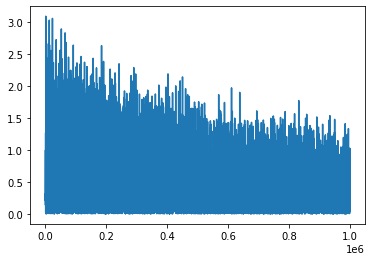

[-3.60674484e-01 -3.35152863e-01  6.29234011e+00  1.22529669e-02
 -1.77391843e-02  1.19090024e-01  1.26412924e-01  7.00251747e-03
  3.53980097e+00  2.01024009e-02 -5.80177410e-02  2.12676558e-02
  4.60548170e-02 -3.05097705e-01  6.23305946e+00  5.46551587e-02
  3.89163547e-02  1.26400123e-01  6.37274721e-03 -2.28132857e-02
  3.61466799e+00  5.46740627e-03 -6.04013869e-02  7.88697124e-02
 -8.66062722e-01 -1.01842445e+00  9.27466190e+00  1.32857378e-01
  2.54173492e-01 -2.47488101e-01 -1.50968177e-01 -3.91139684e-02
  4.24619211e+00  1.21418087e-01 -2.05759275e-01 -4.45349264e-02
 -2.25559963e-01]


In [11]:
plt.plot(deltas)
plt.show()
print(model.theta)

In [12]:
 # Obtain Optimal Semi Gradient Sarsa(0) Policy
import itertools
# determine the policy from Q*
# find V* from Q*
sarsa_policy = {}
sarsa_V = {}
sarsa_Q = {}

# get all possible state combinations
single_state_values = [-1,0,1]
possible_states = list(itertools.product(single_state_values, single_state_values))
for s in possible_states:
  Qs = getQs(model, s)
  sarsa_Q[s] = Qs
  a, max_q = max_dict(Qs)
  sarsa_policy[s] = a
  sarsa_V[s] = max_q

In [13]:
def get_optimal_action_from_policy(state, policy):
  s = convert_cont_states_to_tuple(state)
  discrete_action = policy[s]
  action = get_continuous_actions_from_discrete(discrete_action, state)
  return action

In [22]:
# Testing Semi Gradient Sarsa(0) learned policy on custom environment
num_iters = 100
sarsa_ep_rewards = []
for tests in range(num_iters):
  obs = env.reset()
  done = False
  total_reward = 0
  while not done:
    action = get_optimal_action_from_policy(obs, sarsa_policy)
    obs, reward, done, i = env.step(action)
    total_reward += reward
  # print('Total Reward Collected: {}' .format(total_reward))
  sarsa_ep_rewards.append(total_reward)

In [15]:
"""
https://github.com/Wongcheukwai/David-Silver-Reinforcement-Learning/blob/master/tile_coding.py
"""

""" 
Title: Tile Coding
Author: Wongcheukwai
Date Accessed: May 07, 2021
Availability: https://github.com/Wongcheukwai/David-Silver-Reinforcement-Learning/blob/master/tile_coding.py"""


basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)

    def fullp (self):
        return len(self.dictionary) >= self.size

    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrawidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

In [16]:
class LambdaModel():
    """
    Linear action-value (q-value) function approximator for 
    semi-gradient methods with state-action featurization. 
    """
    
    def __init__(self, num_tilings=8, max_size=37, tiling_dim=None):
        
        self.max_size = max_size

        self.num_tilings = num_tilings
        self.tiling_dim = tiling_dim or num_tilings


        # Initialize index hash table (IHT) for tile coding.
        # This assigns a unique index to each tile up to max_size tiles.
        # Ensure max_size >= total number of tiles (num_tilings x tiling_dim x tiling_dim)
        # to ensure no duplicates.
        self.iht = IHT(max_size)

        # Initialize weights and eligibility trace vector
        self.weights = np.zeros(max_size)

        self.z = np.zeros(max_size)
  
        # Tilecoding software partitions at integer boundaries, so must rescale
        # road_turn and road_position space to span tiling_dim x tiling_dim region.
        self.road_turn_scale = self.tiling_dim / (env.observation_space[0].high \
                                                  - env.observation_space[0].low)
        self.road_pos_scale = self.tiling_dim / (env.observation_space[1].high \
                                                  - env.observation_space[1].low)
        
    def featurize_state_action(self, state, action):
        """
        Returns the featurized representation for a 
        state-action pair.
        """
        featurized = tiles(self.iht, self.num_tilings, 
                              [
                                self.road_turn_scale * state[0], 
                                self.road_pos_scale * state[1]
                              ],[action]
                           )
        return featurized

    # def featurize_state_action(self, state, action):
    #     """
    #     Returns the featurized representation for a 
    #     state-action pair.
    #     Here since we have assumed 3 possible discrete vaues for each state (-1,0 and 1) and there are six actions. We can consider a binary feature array of size 3+3+6. 
    #     The boolean value of first 3 indices can be thought of as presence of feature .
    #     """
    #     featurize = np.zeros(12)
    #     # For 1st state, since discrete value ranges from -1 to 1. Adding 1 to get position
    #     featurize[state[0]+1] = 1

    #     # For 2nd state, since discrete value ranges from -1 to 1. Adding 3 to get position since 0,1,2 belong to first state
    #     featurize[state[1]+3] = 1

    #     # For action, since there are 6 possible discrete actions given under ALL_POSSIBLE_ACTIONS. Let us consider the position index of action for featurization
    #     featurize[action+6] = 1

    #     return featurize

    
    def predict(self, s, a=None):
        """
        Predicts q-value(s) using linear FA.
        """
        if a is None:
            features = [self.featurize_state_action(s, i) for 
                        i in range(len(ALL_POSSIBLE_ACTIONS))]
        else:
            features = [self.featurize_state_action(s, a)]
        return [np.sum(self.weights[f]) for f in features]
        
            
    def update(self, s, a, target, alpha):
        """
        Updates the weight vector based on the eligibility trace and TD error
        """
        features = self.featurize_state_action(s, a)
        estimation = np.sum(self.weights[features])  # Linear FA
        delta = (target - estimation)
        
        # self.z[features] += 1  # Accumulating trace
        self.z[features] = 1  # Replacing trace
        self.weights += alpha * delta * self.z
    

    def reset_trace(self):
        """
        Resets the eligibility trace (must be done at the start of every epoch)
        """
        self.z = np.zeros(self.max_size)



def make_epsilon_greedy_policy(estimator, epsilon, num_actions):
    """
    Creates an epsilon-greedy policy
    """
    def policy_fn(observation):
        action_probs = np.ones(num_actions, dtype=float) * epsilon / num_actions
        q_values = estimator.predict(observation)
        best_action_idx = np.argmax(q_values)
        action_probs[best_action_idx] += (1.0 - epsilon)
        return action_probs
    return policy_fn

In [17]:
estimator = LambdaModel()
lmbda = 0.92  # Level of bootstrapping (set to intermediate value)


# repeat until convergence
t = 1.0
t2 = 1.0
sl_deltas = []

# For each episode
for it in range(1000):
  if it % 100 == 0:
    t += 0.01
    t2 += 0.01
  if it % 1000 == 0:
    print("iteration:", it)
  alpha = ALPHA / t2
    
  # Reset the eligibility trace
  estimator.reset_trace()

   # Create epsilon-greedy policy
  policy = make_epsilon_greedy_policy(estimator, 0.5/t, len(ALL_POSSIBLE_ACTIONS))
  # Reset the environment and pick the first action
  s = env.reset()
  done = False

  # conversion of continuous states to tuple of discrete states
  s = convert_cont_states_to_tuple(s)
  # random action at start
  action_probs = policy(s)
  a = np.random.choice(np.arange(len(action_probs)), p=action_probs)
  biggest_change = 0
  while not done:
    # Take a step
    # need to convert discrete action to continuous
    a = get_continuous_actions_from_discrete(ALL_POSSIBLE_ACTIONS[a], s)
    s2, r, done, i = env.step(a)
    s2 = convert_cont_states_to_tuple(s2)

    old_theta = estimator.weights.copy()
    if done:
        # terminal state
        estimator.update(s, a, r, alpha)
    else:
      # Take next step
      a2_probs = policy(s2)
      a2 = np.random.choice(np.arange(len(a2_probs)), p=a2_probs)

      # Estimate q-value at next state-action
      q2 = estimator.predict(s2, a2)[0]
      target = r + GAMMA * q2

      # Update weights step
      estimator.update(s, a, target, alpha)
      estimator.z *= GAMMA * lmbda

      s = s2
      a = a2

    biggest_change = max(biggest_change, np.abs(estimator.weights - old_theta).sum())
    sl_deltas.append(biggest_change)

iteration: 0
IHT full, starting to allow collisions


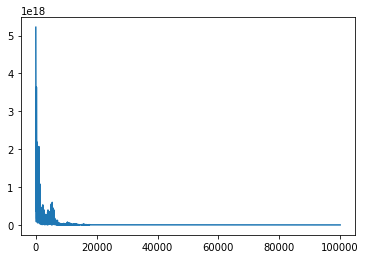

In [28]:
plt.plot(sl_deltas[::-1])
plt.show()

In [19]:
# Obtaining optimal Sarsa Lambda Policy
sarsa_l_policy = {}
sarsa_l_V = {}
sarsa_l_Q = {}

# get all possible state combinations
single_state_values = [-1,0,1]
possible_states = list(itertools.product(single_state_values, single_state_values))
for s in possible_states:
  Qs = getQs(estimator, s)
  # converting q-value from list with one value to single value
  Qs = {k:v[0] for k,v in Qs.items()}
  sarsa_l_Q[s] = Qs
  a, max_q = max_dict(Qs)
  sarsa_l_policy[s] = a
  sarsa_l_V[s] = max_q

In [20]:
# Testing Sarsa lambda learned policy
sarsa_l_ep_rewards = []
for tests in range(num_iters):
  obs = env.reset()
  done = False
  total_reward = 0
  while not done:
    action = get_optimal_action_from_policy(obs, sarsa_l_policy)
    obs, reward, done, i = env.step(action)
    total_reward += reward
  # print('Total Reward Collected: {}' .format(total_reward))
  sarsa_l_ep_rewards.append(total_reward)

In [23]:
# Comparison
print('Average reward over {} trails for Semi Gradient Sarsa(0): {}'.format(num_iters, np.mean(sarsa_ep_rewards)))
print('Standard Deviation reward over {} trails for Semi Gradient Sarsa(0): {}'.format(num_iters, np.std(sarsa_ep_rewards)))

print('Average reward over {} trails for Sarsa lambda: {}'.format(num_iters, np.mean(sarsa_l_ep_rewards)))
print('Standard Deviation reward over {} trails for Sarsa lambda: {}'.format(num_iters, np.std(sarsa_l_ep_rewards)))

Average reward over 100 trails for Semi Gradient Sarsa(0): 93.8
Standard Deviation reward over 100 trails for Semi Gradient Sarsa(0): 14.542351941828391
Average reward over 100 trails for Sarsa lambda: 99.3
Standard Deviation reward over 100 trails for Sarsa lambda: 0.9539392014169458


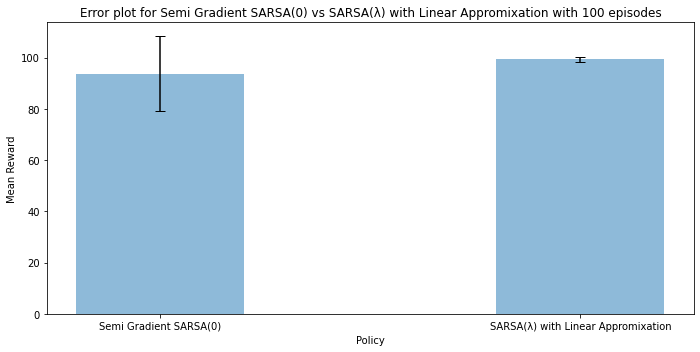

In [24]:
plt.figure(figsize=(10,5))
plt.bar(['Semi Gradient SARSA(0)','SARSA(λ) with Linear Appromixation'], [np.mean(sarsa_ep_rewards), np.mean(sarsa_l_ep_rewards)], yerr=[np.std(sarsa_ep_rewards), np.std(sarsa_l_ep_rewards)], align='center', alpha=0.5, ecolor='black', capsize=5, width=[.4]*2)
plt.title('Error plot for Semi Gradient SARSA(0) vs SARSA(λ) with Linear Appromixation with {} episodes'.format(num_iters))
plt.ylabel('Mean Reward')
plt.xlabel('Policy')
plt.xticks(['Semi Gradient SARSA(0)','SARSA(λ) with Linear Appromixation'])
plt.tight_layout()